# ***Major League Cricket Data Analysis***
### by [***Anthahkarana***](https://anthahkarana.tech)

### **Fourth Round of Analysis**
Trying out more things with respect to the 2024 season.Feel free to use the display command after any of the cells to see how the data looks after each of them..

Defining the Folder Path where I have uploaded the ball-by-ball database of every MLC match. Credits to [CricSheet](https://cricsheet.org)

In [26]:
folder_path='/content/mlc_json'

Loading the necessary models and creating a variable which can load all the JSON files.

In [27]:
import pandas as pd
import glob
import os
import json


all_files = glob.glob(os.path.join(folder_path, "*.json"))



All the JSON files by cricsheet are well-defined with comprehensive data. Some of them just need to be connected in order to perform further analysis. Here, I am map each player to their respective team for the 2024 season.

In [28]:
# Dictionary to store player-to-team mappings across all files
team_mapping = {}

# Process each JSON file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):  # Process only JSON files
        file_path = os.path.join(folder_path, filename)

        # Load the JSON data
        with open(file_path, 'r') as file:
            match_data = json.load(file)

        season = match_data.get('info', {}).get('season')
        if season != '2024':
            continue

        # Extract players and registry data
        players_data = match_data.get('info', {}).get('players', {})
        registry_data = match_data.get('info', {}).get('registry', {}).get('people', {})

        # Create the player-to-team mapping for this file
        for team, players in players_data.items():
            for player_short_name in players:
                for full_player_name, player_id in registry_data.items():
                    if player_short_name == full_player_name:
                        team_mapping[full_player_name] = team
                        break

# Print the resulting dictionary
print(team_mapping)


{'JJ Roy': 'Los Angeles Knight Riders', 'SP Narine': 'Los Angeles Knight Riders', 'UBT Chand': 'Los Angeles Knight Riders', 'Shakib Al Hasan': 'Los Angeles Knight Riders', 'DA Miller': 'Los Angeles Knight Riders', 'AD Russell': 'Los Angeles Knight Riders', 'Saif Badar': 'Los Angeles Knight Riders', 'NR Kumar': 'Los Angeles Knight Riders', 'CA Dry': 'Los Angeles Knight Riders', 'SH Johnson': 'Los Angeles Knight Riders', 'Ali Khan': 'Los Angeles Knight Riders', 'RD Rickelton': 'Seattle Orcas', 'Nauman Anwar': 'Seattle Orcas', 'Q de Kock': 'Seattle Orcas', 'Shubham Ranjane': 'Seattle Orcas', 'H Klaasen': 'Seattle Orcas', 'Imad Wasim': 'Seattle Orcas', 'Hammad Azam': 'Seattle Orcas', 'Harmeet Singh': 'Seattle Orcas', 'N Burger': 'Seattle Orcas', 'Zaman Khan': 'Seattle Orcas', 'CJ Gannon': 'Seattle Orcas', 'TM Head': 'Washington Freedom', 'SPD Smith': 'Washington Freedom', 'AGS Gous': 'Washington Freedom', 'GJ Maxwell': 'Washington Freedom', 'R Ravindra': 'Washington Freedom', 'AJ Pienaar':

Trying to draw a scatter-plot now with runs and balls as th two parameters, processing the data..

In [29]:
player_stats = {}  # Store runs and balls faced for each player

for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2024':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):
            for delivery in over.get('deliveries', []):
                batter_name = delivery.get('batter')
                runs_scored = delivery.get('runs', {}).get('batter', 0)
                is_wide = delivery.get('extras', {}).get('wides', 0) > 0
                is_no_ball = delivery.get('extras', {}).get('noballs', 0) > 0

                batter_identifier = registry.get(batter_name)

                if batter_identifier:
                    if batter_name not in player_stats:
                        player_stats[batter_name] = {'runs': 0, 'balls': 0}

                    player_stats[batter_name]['runs'] += runs_scored
                    if not is_wide:  # Count balls faced excluding wides
                        player_stats[batter_name]['balls'] += 1

Trying to install a library which can make the graph interactive..

In [30]:
!pip install mplcursors

Plotting the scatter-plot

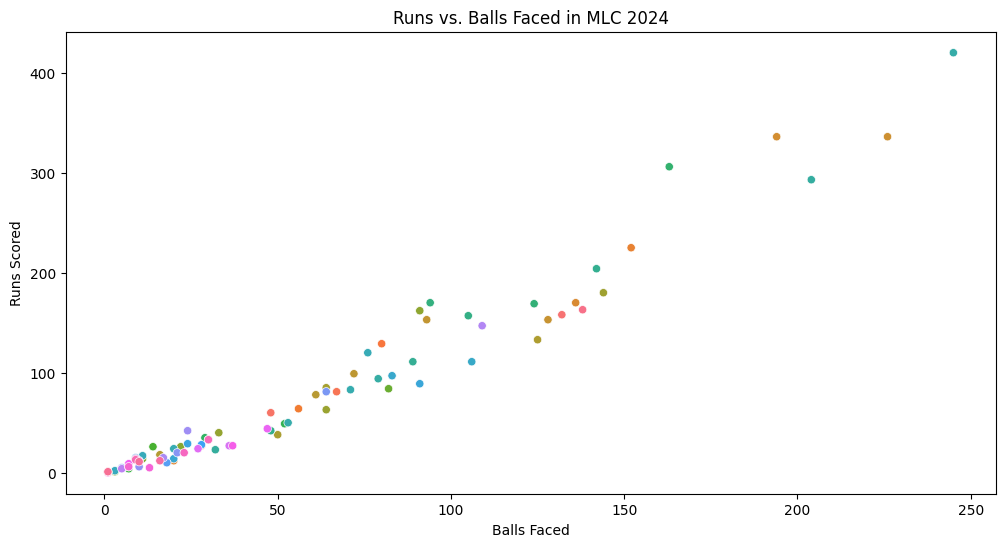

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mplcursors


# Convert player_stats to DataFrame
df = pd.DataFrame(player_stats).T.reset_index()
df.columns = ['Player', 'Runs', 'Balls']

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 6))
scatter = sns.scatterplot(x='Balls', y='Runs', data=df, hue='Player', legend=False, ax=ax)

# Create annotation object (initially hidden)
annot = ax.annotate("", xy=(0, 0), xytext=(20, 20), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

# Function to update annotation text and position
def update_annot(sel):
    index = sel.target.index
    annot.xy = sel.target
    annot.set_text(df['Player'][index])
    annot.get_bbox_patch().set_alpha(0.4)
    annot.set_visible(True)

# Connect hover event to update_annot function
cursor = mplcursors.cursor(scatter, hover=True)
cursor.connect("add", update_annot)

# Customize plot (as before)
plt.title('Runs vs. Balls Faced in MLC 2024')
plt.xlabel('Balls Faced')
plt.ylabel('Runs Scored')

# Show the plot
plt.show()


As we can see Faf Du Plessis is on top of the charts. This graph also allows us to see how fast individual batsem are with respect to scoring runs. One noticeable element is that Finn Allen scoring more runs than Devon Conway with around 40 lesser balls. And post 150 runs, we see only fewer players who are establishing their class!

Now trying distribution graph..

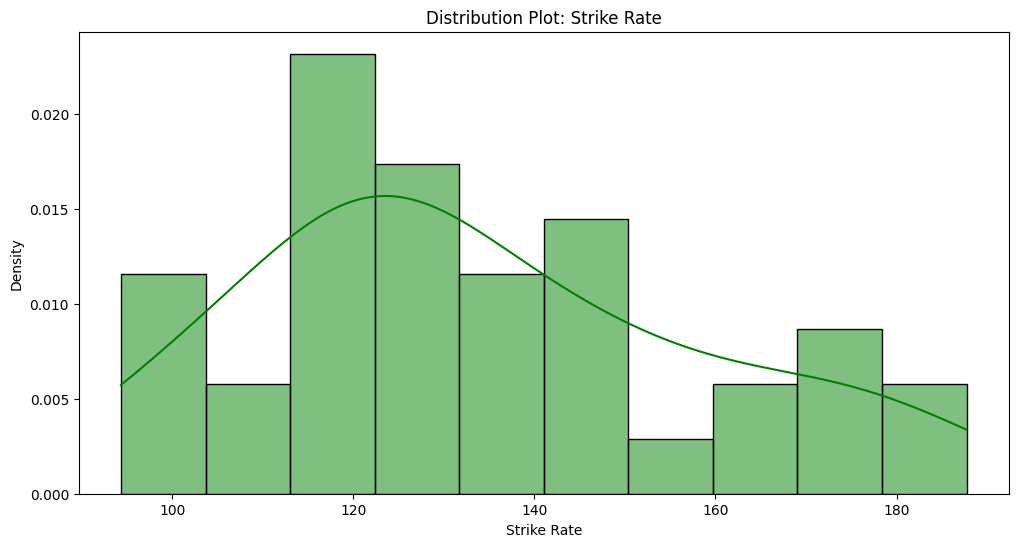

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert player_stats to DataFrame
df = pd.DataFrame(player_stats).T.reset_index()
df.columns = ['Player', 'Runs', 'Balls']

# Calculate Strike Rate
df['Strike Rate'] = (df['Runs'] / df['Balls']) * 100

# Filter the DataFrame for players with runs >= 50 since lesser runs might not give accurate results.
df_filtered = df[df['Runs'] >= 50]

# Create a distribution plot for Strike Rate
plt.figure(figsize=(12, 6))

# Plot the distribution of 'Strike Rate'
sns.histplot(data=df_filtered, x='Strike Rate', kde=True, color='green', stat='density', bins=10)

# Customize plot
plt.title('Distribution Plot: Strike Rate')
plt.xlabel('Strike Rate')
plt.ylabel('Density')

# Show the plot
plt.show()


This shows that the region around 120 is strike rate which most batsmen have, emphasizing the role big-hitters have as they are rare in this format..

Now trying to do something a bit more complex which will shed some light on batsmen effectiveness..

In [33]:
import pandas as pd

# Convert player_stats to DataFrame
df_player_stats = pd.DataFrame(player_stats).T.reset_index()

# Rename columns
df_player_stats.columns = ['Player', 'Runs', 'Balls']

# Calculate Strike Rate
df_player_stats['Strike Rate'] = (df_player_stats['Runs'] / df_player_stats['Balls']) * 100

Calculating the number of times a batsman has gotten out

In [34]:
dismissals = {}  # Dictionary to store dismissals

for file in all_files:
    with open(file, 'r') as f:
        match_data = json.load(f)

    season = match_data.get('info', {}).get('season')
    if season != '2024':
        continue

    registry = match_data.get('info', {}).get('registry', {}).get('people', {})

    for inning in match_data.get('innings', []):
        for over in inning.get('overs', []):
            for delivery in over.get('deliveries', []):
                if 'wickets' in delivery:
                    for wicket in delivery['wickets']:
                        batter_name = wicket.get('player_out')
                        if batter_name:  # Check if batter_name is not None
                            dismissals[batter_name] = dismissals.get(batter_name, 0) + 1

Now, finding the Average

In [35]:
# Calculate average and add to DataFrame
df_player_stats['Average'] = 0.0  # Initialize the column

for index, row in df_player_stats.iterrows():
    player = row['Player']
    runs = row['Runs']
    outs = dismissals.get(player, 0)  # Get dismissals, default to 0 if not found

    if outs > 0:
        average = runs / outs
    else:
        average = float('inf')  # or any other suitable value for 0 dismissals

    df_player_stats.loc[index, 'Average'] = average



Trying to provide a normalized score out here on a scale of 1-5 based on the number of runs scored..

In [36]:
# Find minimum and maximum runs
min_runs = df_player_stats['Runs'].min()
max_runs = df_player_stats['Runs'].max()

# Calculate normalized scores and add to DataFrame
df_player_stats['Runs Score'] = (((df_player_stats['Runs'] - min_runs) / (max_runs - min_runs)) * 4) + 1

display(df_player_stats)

,Player,Runs,Balls,Strike Rate,Average,Runs Score
0,JJ Roy,163,138,118.115942,27.166667,2.552381
1,SP Narine,27,28,96.428571,4.500000,1.257143
2,UBT Chand,158,132,119.696970,26.333333,2.504762
3,Shakib Al Hasan,60,48,125.000000,15.000000,1.571429
4,DA Miller,81,67,120.895522,16.200000,1.771429
...,...,...,...,...,...,...
81,DJ Bravo,13,9,144.444444,13.000000,1.123810
82,K Rabada,1,1,100.000000,inf,1.009524
83,SC van Schalkwyk,12,16,75.000000,inf,1.114286
84,Ali Khan,11,10,110.000000,5.500000,1.104762


Providing an average score
where if a batsman has infinity average i.e. not even out once in the tournament


*   Score is 3 if he has scored more than 50 runs
*   Else score is 1.5

For all the other cases, it is a normalized score on a scale of 1-5



In [37]:
# Handle infinity values in 'Average'
df_player_stats.loc[(df_player_stats['Average'] == float('inf')) & (df_player_stats['Runs'] > 50), 'Average'] = 3
df_player_stats.loc[(df_player_stats['Average'] == float('inf')) & (df_player_stats['Runs'] <= 50), 'Average'] = 1.5

# Normalize Average
def normalize_column(df, column):
    min_val = df[column].min()
    max_val = df[column].max()
    df[column + ' Score'] = (((df[column] - min_val) / (max_val - min_val)) * 4) + 1
    return df

df_player_stats = normalize_column(df_player_stats, 'Average')



A Normalized score for strike rate now, where the score is 0.75 by default if the Strike Rate is below 100. Otherwise it is a normalized score between 1-5

In [38]:
# Normalize Strike Rate
df_player_stats['Strike Rate Score'] = 0.75  # Initialize with 0.75 for SR below 100

df_filtered = df_player_stats[df_player_stats['Strike Rate'] >= 100]
min_sr = df_filtered['Strike Rate'].min()
max_sr = df_filtered['Strike Rate'].max()

df_player_stats.loc[df_player_stats['Strike Rate'] >= 100, 'Strike Rate Score'] = (((df_filtered['Strike Rate'] - min_sr) / (max_sr - min_sr)) * 4) + 1

Dividing both of these scores by 2 to have them equal to a maximum of 5 when added

In [39]:
df_player_stats['Average Score'] = df_player_stats['Average Score']/2
df_player_stats['Strike Rate Score'] = df_player_stats['Strike Rate Score']/2
df_player_stats['Total Score'] = df_player_stats['Runs Score'] + df_player_stats['Average Score'] + df_player_stats['Strike Rate Score']
display(df_player_stats)

,Player,Runs,Balls,Strike Rate,Average,Runs Score,Average Score,Strike Rate Score,Total Score
0,JJ Roy,163,138,118.115942,27.166667,2.552381,1.470238,0.912993,4.935612
1,SP Narine,27,28,96.428571,4.500000,1.257143,0.660714,0.375000,2.292857
2,UBT Chand,158,132,119.696970,26.333333,2.504762,1.440476,0.949036,4.894274
3,Shakib Al Hasan,60,48,125.000000,15.000000,1.571429,1.035714,1.069930,3.677073
4,DA Miller,81,67,120.895522,16.200000,1.771429,1.078571,0.976359,3.826359
...,...,...,...,...,...,...,...,...,...
81,DJ Bravo,13,9,144.444444,13.000000,1.123810,0.964286,1.513209,3.601304
82,K Rabada,1,1,100.000000,1.500000,1.009524,0.553571,0.500000,2.063095
83,SC van Schalkwyk,12,16,75.000000,1.500000,1.114286,0.553571,0.375000,2.042857
84,Ali Khan,11,10,110.000000,5.500000,1.104762,0.696429,0.727972,2.529163


Exporting them to a file, which is batsman_stats

In [40]:
df_batsman_stats = df_player_stats
df_batsman_stats.to_csv('batsman_stats.csv', index=False)

Renaming certain fields because I have to consider both batting and bowling scores in order to calculate the total scores

In [41]:
# Load the batsman stats CSV file
df_batsman_stats = pd.read_csv('batsman_stats.csv')

# Rename the 'Total Score' column to 'Batting Score'
df_batsman_stats = df_batsman_stats.rename(columns={'Total Score': 'Batting Score'})

# Export the modified DataFrame back to CSV
df_batsman_stats.to_csv('batsman_stats.csv', index=False)

df_bowler_stats = pd.read_csv('bowler_stats.csv')

df_bowler_stats = df_bowler_stats.rename(columns={'Total Score': 'Bowling Score'})

df_bowler_stats.to_csv('bowler_stats.csv', index=False)

In [42]:
#Renaming the batsman_stats csv

df_batsman_stats = pd.read_csv('batsman_stats.csv')

df_batsman_stats = df_batsman_stats.rename(columns={'Strike Rate': 'Batting SR'})
df_batsman_stats = df_batsman_stats.rename(columns={'Average': 'Batting AVG'})
df_batsman_stats = df_batsman_stats.rename(columns={'Strike Rate Score': 'Batting SR Score'})
df_batsman_stats = df_batsman_stats.rename(columns={'Average Score': 'Batting AVG Score'})
df_batsman_stats = df_batsman_stats.rename(columns={'Runs': 'Runs Scored'})
df_batsman_stats = df_batsman_stats.rename(columns={'Strike Rate': 'Batting SR'})
df_batsman_stats = df_batsman_stats.rename(columns={'Balls': 'Balls Faced'})

df_batsman_stats.columns
df_batsman_stats.to_csv('batsman_stats.csv', index=False)

In [43]:
#Renaming the bowler_stats csv

df_bowler_stats = df_bowler_stats.rename(columns={'Total Score': 'Bowling Score'})
df_bowler_stats = df_bowler_stats.rename(columns={'Bowler': 'Player'})
df_bowler_stats = df_bowler_stats.rename(columns={'Wickets': 'Wickets Taken'})
df_bowler_stats = df_bowler_stats.rename(columns={'Average': 'Bowling AVG'})
df_bowler_stats = df_bowler_stats.rename(columns={'Average Score': 'Bowling AVG Score'})
df_bowler_stats = df_bowler_stats.rename(columns={'Strike Rate': 'Bowling SR'})
df_bowler_stats = df_bowler_stats.rename(columns={'Strike Rate Score': 'Bowling SR Score'})


df_bowler_stats.columns

Index(['Player', 'Wickets Taken', 'Wickets Score', 'Runs Conceded',
       'Balls Bowled', 'Bowling AVG', 'Bowling AVG Score', 'Bowling SR',
       'Bowling SR Score', 'Bowling Score'],
      dtype='object')

Now merging both of these files in order to give us the player_stats csv file which combines both of these scores

In [44]:
# Merge the two dataframes
player_stats = pd.merge(df_batsman_stats, df_bowler_stats, on='Player', how='outer')

# Fill NaN values with blank strings
player_stats = player_stats.fillna('')

Replacing empty fields with zero for handling error

And calucating the total score.

In [45]:
# Convert 'Bowling Score' and 'Batting Score' columns to numeric, handling errors
player_stats['Bowling Score'] = pd.to_numeric(player_stats['Bowling Score'], errors='coerce').fillna(0)
player_stats['Batting Score'] = pd.to_numeric(player_stats['Batting Score'], errors='coerce').fillna(0)

# Now we can calculate the 'Total Score'
player_stats['Total Score'] = (player_stats['Batting Score'] + player_stats['Bowling Score']) / 2

Sorting the values by the total score
Reordering the columns for better viewing experience
and exporting them to a new CSV file

In [46]:
# prompt: Sort the player_stats based on the total score and export it to a csv file on the same name

# Sort the player_stats DataFrame by 'Total Score' in descending order
player_stats = player_stats.sort_values(by='Total Score', ascending=False)

player_stats = pd.read_csv('player_stats.csv')

# Define the desired column order
new_column_order = ['Player', 'Total Score', 'Batting Score', 'Bowling Score', 'Runs Scored', 'Wickets Taken']

# Get the remaining columns not in the new order
remaining_columns = [col for col in player_stats.columns if col not in new_column_order]

# Create the final column order
final_column_order = new_column_order + remaining_columns

# Reorder the columns in the DataFrame
player_stats = player_stats[final_column_order]

# Export the reordered DataFrame to a CSV file
player_stats.to_csv('player_stats.csv', index=False)

display(player_stats)

,Player,Total Score,Batting Score,Bowling Score,Runs Scored,Wickets Taken,Balls Faced,Batting SR,Batting AVG,Runs Score,Batting AVG Score,Batting SR Score,Wickets Score,Runs Conceded,Balls Bowled,Bowling AVG,Bowling AVG Score,Bowling SR,Bowling SR Score
0,Rashid Khan,7.006317,6.767969,7.244666,162.0,10.0,91.0,178.021978,40.500000,2.542857,1.946429,2.278683,3.571429,160.0,158.0,16.000000,1.845906,15.800000,1.827331
1,Hassan Khan,6.865722,6.395371,7.336074,204.0,10.0,142.0,143.661972,40.800000,2.942857,1.957143,1.495371,3.571429,156.0,132.0,15.600000,1.856194,13.200000,1.908451
2,GJ Maxwell,6.760172,6.294002,7.226343,153.0,10.0,93.0,164.516129,38.250000,2.457143,1.866071,1.970787,3.571429,170.0,156.0,17.000000,1.822303,15.600000,1.832611
3,R Ravindra,6.604975,4.302854,8.907095,99.0,12.0,72.0,137.500000,14.142857,1.942857,1.005102,1.354895,4.142857,73.0,92.0,6.083333,2.500000,7.666667,2.264238
4,SH Johnson,5.749514,4.665951,6.833078,26.0,9.0,14.0,185.714286,13.000000,1.247619,0.964286,2.454046,3.285714,193.0,151.0,21.444444,1.744034,16.777778,1.803330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Nauman Anwar,1.066071,2.132143,0.000000,12.0,NaN,20.0,60.000000,4.000000,1.114286,0.642857,0.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,DYA Davis,1.035714,2.071429,0.000000,15.0,NaN,17.0,88.235294,1.500000,1.142857,0.553571,0.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,K Rabada,1.031548,2.063095,0.000000,1.0,NaN,1.0,100.000000,1.500000,1.009524,0.553571,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,J Little,0.983333,1.966667,0.000000,4.0,NaN,7.0,57.142857,1.500000,1.038095,0.553571,0.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see, this is not a very fair table. Although the top players like Rashid and Rachin deserve their spots completely, players like Du Plessis and Netravalkar who were on top of batting and bowling charts have stooped very down. And we can see players like Noor Ahmad with just 7 runs scored gaining around 1.2 batting points elevating them up a spot.

So the fairness of this table isn't exactly well-defined. So, what do we do?

I tried adding an extra two points to all the individuals who were in the top five of either of batting or bowling charts. This brings a certain amount of fairness, but is it the ultimate scoring chart? I don't think so.

In [47]:
# Create a copy to avoid modifying the original DataFrame
player_stats_updated = player_stats.copy()

# Find the top 10 players in batting and bowling
top_batters = player_stats_updated.nlargest(5, 'Batting Score')['Player'].tolist()
top_bowlers = player_stats_updated.nlargest(5, 'Bowling Score')['Player'].tolist()

# Combine the lists and get unique players
top_performers = list(set(top_batters + top_bowlers))

# Add +2 to the final score for top performers
for player in top_performers:
    player_stats_updated.loc[player_stats_updated['Player'] == player, 'Total Score'] += 2

# Display the updated DataFrame
display(player_stats_updated)

,Player,Total Score,Batting Score,Bowling Score,Runs Scored,Wickets Taken,Balls Faced,Batting SR,Batting AVG,Runs Score,Batting AVG Score,Batting SR Score,Wickets Score,Runs Conceded,Balls Bowled,Bowling AVG,Bowling AVG Score,Bowling SR,Bowling SR Score
0,Rashid Khan,7.006317,6.767969,7.244666,162.0,10.0,91.0,178.021978,40.500000,2.542857,1.946429,2.278683,3.571429,160.0,158.0,16.000000,1.845906,15.800000,1.827331
1,Hassan Khan,8.865722,6.395371,7.336074,204.0,10.0,142.0,143.661972,40.800000,2.942857,1.957143,1.495371,3.571429,156.0,132.0,15.600000,1.856194,13.200000,1.908451
2,GJ Maxwell,6.760172,6.294002,7.226343,153.0,10.0,93.0,164.516129,38.250000,2.457143,1.866071,1.970787,3.571429,170.0,156.0,17.000000,1.822303,15.600000,1.832611
3,R Ravindra,8.604975,4.302854,8.907095,99.0,12.0,72.0,137.500000,14.142857,1.942857,1.005102,1.354895,4.142857,73.0,92.0,6.083333,2.500000,7.666667,2.264238
4,SH Johnson,5.749514,4.665951,6.833078,26.0,9.0,14.0,185.714286,13.000000,1.247619,0.964286,2.454046,3.285714,193.0,151.0,21.444444,1.744034,16.777778,1.803330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Nauman Anwar,1.066071,2.132143,0.000000,12.0,NaN,20.0,60.000000,4.000000,1.114286,0.642857,0.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,DYA Davis,1.035714,2.071429,0.000000,15.0,NaN,17.0,88.235294,1.500000,1.142857,0.553571,0.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,K Rabada,1.031548,2.063095,0.000000,1.0,NaN,1.0,100.000000,1.500000,1.009524,0.553571,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,J Little,0.983333,1.966667,0.000000,4.0,NaN,7.0,57.142857,1.500000,1.038095,0.553571,0.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<ipython-input-48-afa124efad50>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total Score', y='Player', data=top_fifteen, palette='viridis')


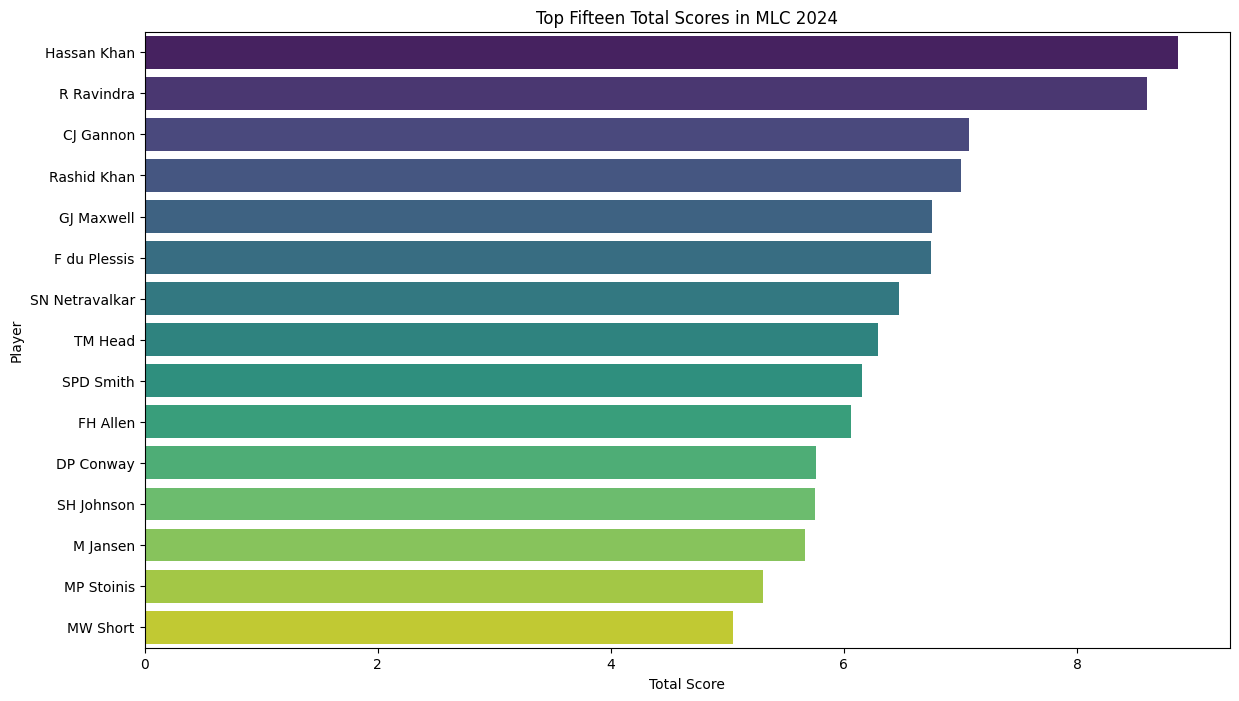

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the DataFrame by 'Total Score' in descending order
player_stats_updated = player_stats_updated.sort_values(by='Total Score', ascending=False)

# Get the top fifteen players
top_fifteen = player_stats_updated.head(15)

plt.figure(figsize=(14, 8))
sns.barplot(x='Total Score', y='Player', data=top_fifteen, palette='viridis')
plt.title('Top Fifteen Total Scores in MLC 2024')
plt.xlabel('Total Score')
plt.ylabel('Player')
plt.show()

https://www.espncricinfo.com/series/major-league-cricket-2024-1432722/most-valuable-players

Consider this advanced chart by ESPNCricinfo, although they have more metrics and match scenarios taken into account for a better understanding of the game - our chart has the top nine players in that list out here in this top fifteen. That's a good development!

Take for instance this normal distribution table of the amount of runs scored by an individual. Faf Du Plessis is a cut above every one else but he isn't even in the top five of the above list. How do we make it more fair ?

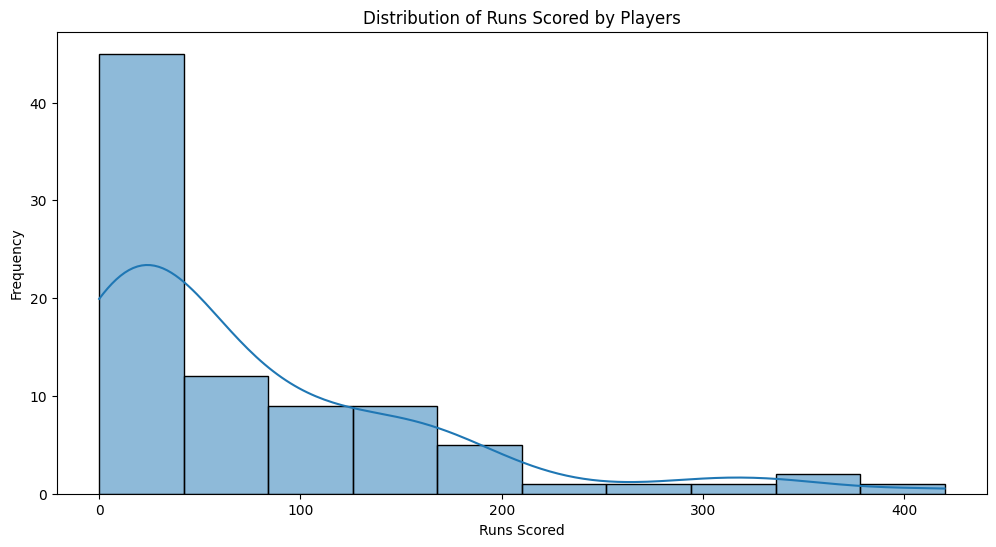

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the player stats
player_stats = pd.read_csv('player_stats.csv')

# Assuming 'Runs Scored' column contains the runs scored by each player
plt.figure(figsize=(12, 6))
sns.histplot(player_stats['Runs Scored'], kde=True)
plt.title('Distribution of Runs Scored by Players')
plt.xlabel('Runs Scored')
plt.ylabel('Frequency')
plt.show()